In [10]:
import pennylane as qml
import numpy as np 

def unitary_check(operator):
    return np.allclose(np.identity(operator.shape[0]), np.dot(operator, np.transpose(np.conjugate(operator))))

unitary_check(qml.T.compute_matrix())

True

(<Figure size 500x200 with 1 Axes>, <Axes: >)

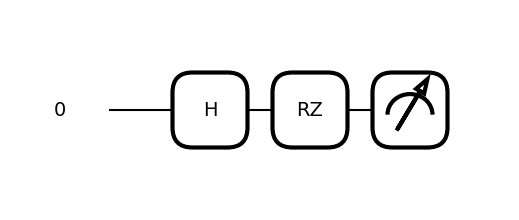

In [14]:
dev = qml.device("default.qubit", wires=1)

def evolve_plus_state(B, time):
    e = 1.6e-19
    m_e = 9.1e-31
    alpha = B*e/(2*m_e)
    qml.Hadamard(0)
    qml.RZ(-2*alpha*time, wires=0)
    
@qml.qnode(dev)
def mag_z_plus_X(B, time):
    evolve_plus_state(B, time)
    return qml.expval(qml.PauliX(0))

@qml.qnode(dev)
def mag_z_plus_Y(B, time):
    evolve_plus_state(B, time)
    return qml.expval(qml.PauliY(0))

qml.draw_mpl(mag_z_plus_X)(0.1, 0.6)


### Linear combination of unitaries.

In [18]:
aux = 0
main = 1
n_bits = 2
dev = qml.device("default.qubit", wires=n_bits)

def add_two_unitaries(U, V):
    qml.Hadamard(wires=aux)
    qml.ControlledQubitUnitary(U, control_wires=[0], wires=1, control_values=[0])
    qml.ControlledQubitUnitary(V, control_wires=[0], wires=1, control_values=[1])
    qml.Hadamard(wires=aux)

@qml.qnode(dev)
def X_plus_Z():
    add_two_unitaries(qml.PauliX.compute_matrix(), qml.PauliZ.compute_matrix())
    return qml.state()

print("The amplitudes on the main register are proportional to", X_plus_Z()[:2], ".")


The amplitudes on the main register are proportional to [0.5+0.j 0.5+0.j] .


### Implement unitary for the following. 

$ H \otimes X + H \otimes Z $
$ = (X + Z) \otimes X + (X + Z) \otimes Z = X \otimes X + Z \otimes Z + X \otimes Z + Z \otimes X $

The amplitudes on the main register are proportional to [ 0.25+0.j -0.25+0.j  0.25+0.j -0.25+0.j] .


/Users/venkat/opt/anaconda3/envs/QCML/lib/python3.9/site-packages/pennylane/ops/op_math/controlled.py:253: UserWarning: Specifying control values as a string is deprecated. Please use Sequence[Bool]
  warnings.warn(


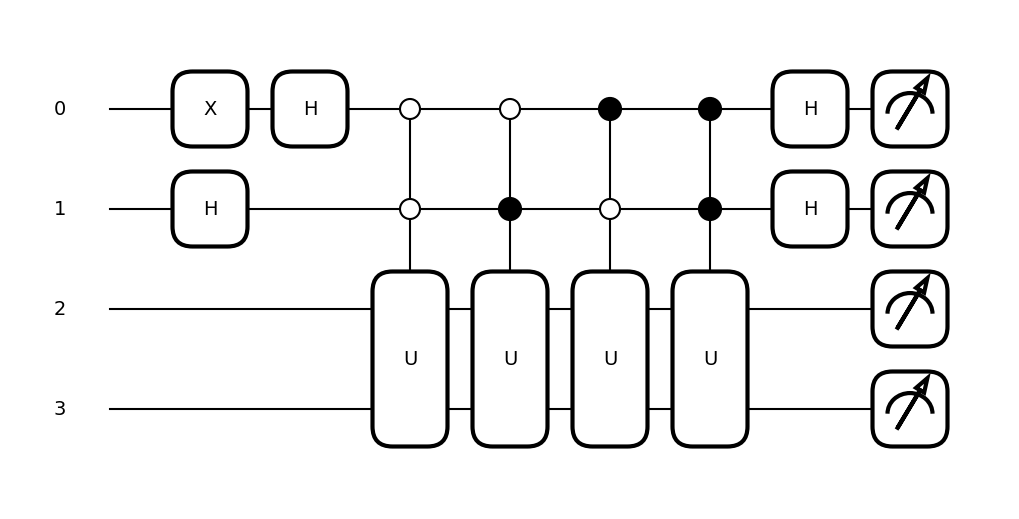

In [51]:
k_bits = 2
n_bits = 2
all_bits = k_bits + n_bits
aux = range(k_bits)
main = range(k_bits, all_bits)
dev = qml.device("default.qubit", wires=all_bits)

def SELECT_uniform(U_list):
    for index in range(2**k_bits):
        ctrl_str =  np.binary_repr(index, k_bits) # Create binary representation
        qml.ControlledQubitUnitary(U_list[index], control_wires=aux, wires=main, control_values=ctrl_str)

@qml.qnode(dev)
def XH_plus_HZ():
    """Apply XH + HZ to |01> and return the state."""
    
    U_list = [
        np.kron(qml.PauliX.compute_matrix(), qml.PauliX.compute_matrix()),
        np.kron(qml.PauliZ.compute_matrix(), qml.PauliX.compute_matrix()),
        np.kron(qml.PauliX.compute_matrix(), qml.PauliZ.compute_matrix()),
        np.kron(qml.PauliZ.compute_matrix(), qml.PauliZ.compute_matrix()),
    ]
    
    qml.PauliX(0)
    
    for i in aux:
        qml.Hadamard(i)
    
    SELECT_uniform(U_list[::-1])
    
    for i in aux:
        qml.Hadamard(i)    
    
    return qml.state()

qml.draw_mpl(XH_plus_HZ)()

print("The amplitudes on the main register are proportional to", XH_plus_HZ()[:4], ".")
